In [1]:
import os
from fastai.vision.all import *
from fastai.distributed import *
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from fastai.vision.all import *
import cv2
from fastai.distributed import *
import click, argparse
import warnings
warnings.filterwarnings('ignore')

Reading images for training from train.txt 
and for validation from valid.txt 

Aim is to get the highest R2 score on validation data 

In [2]:
train_img_files = pd.read_csv("train.txt", names=["imgs"])
train_img_files = train_img_files["imgs"]

print(f"Total images for training are {len(train_img_files)}")

valid_img_files = pd.read_csv("valid.txt", names=["imgs"])

valid_img_files = valid_img_files["imgs"]

print(f"Total images for validation are {len(valid_img_files)}")

Total images for training are 672
Total images for validation are 289


We will use sklearn to standardise our data. We will first calculate the mean and variance of the 4 features and then scale the data to have zero mean and 1 variance. 

For more info [see](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [3]:
sc = StandardScaler()

In [4]:
def get_df(img_files,train_data=True):
    ku1, alphas, aexs, temp    = [],[],[],[]
    for ii, value in enumerate(img_files):
        value = value.split("/")[-1]
        if len(value.split('_')) == 4:
            ku1.append(value.split('_')[0])
            alphas.append(value.split('_')[1])
            aexs.append(value.split('_')[2])
            temp.append(value.split('_')[3].strip('.jpg'))
            
    ku1    = pd.Series(ku1,    name='ku1').astype(int)
    alphas = pd.Series(alphas, name='alphas').astype(float)
    aexs   = pd.Series(aexs,   name='aexs').astype(float)
    temp   = pd.Series(temp,   name='temp').astype(float)
    
    
    df = pd.concat([img_files, ku1, alphas, aexs, temp], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
    if (train_data):
        normVal= sc.fit_transform(df.values[:,1:]) # for training data 
    else:
        normVal= sc.transform(df.values[:,1:]) # for test data 
    df['nku1'],df['nalphas'],df['naexs'],df['ntemp'] = normVal[:,0],normVal[:,1], normVal[:,2], normVal[:,3]
    return df

We call transform on validation data so that mean and variance of the training data is used to standadize the validating data. 

In [5]:
df_train = get_df(train_img_files,train_data=True)
df_valid = get_df(valid_img_files,train_data=False)

We need to get an idea about the maximum and minimum value of each of the outputs. This is required when we want to use pretrained networks. The outerlayer of such pretrained networks is sigmoid and we need to define a range of the expected outcomes. 

In [6]:
def get_x(r):
    r = r["imgs"]
    image = Image.open(r, mode="r")
    image = image.convert('RGB')
    image = image.resize((256,256))
    return tensor(image)

def get_y(r):
    return tensor([r['nku1'],r['nalphas'],r['naexs'],r['ntemp']])

In [7]:
dblock = DataBlock((ImageBlock, RegressionBlock),
                           get_x = get_x, get_y = get_y,
                           splitter = RandomSplitter(valid_pct=0.0),
                           batch_tfms=[*aug_transforms(size=(256,256)),
                                       Normalize.from_stats(*imagenet_stats)]) 

dls = dblock.dataloaders(df_train,bs=32, shuffle=True) # training data 
dls_valid = dblock.dataloaders(df_valid,bs=32, shuffle=True) # validation data  
dls.valid = dls_valid.train # updating validation data of training dataloader 

print (f"Dataloader has {len(dls.train.items)} training images and {len(dls.valid.items)} validating images")

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Dataloader has 672 training images and 289 validating images


In [8]:
images , values = dls.one_batch() # getting sense of one batch 
print(images[0].shape , values[0]) # getting sense of one datapoint of a batch 

torch.Size([3, 256, 256]) tensor([-0.4410,  0.1976, -0.7537,  1.6800])


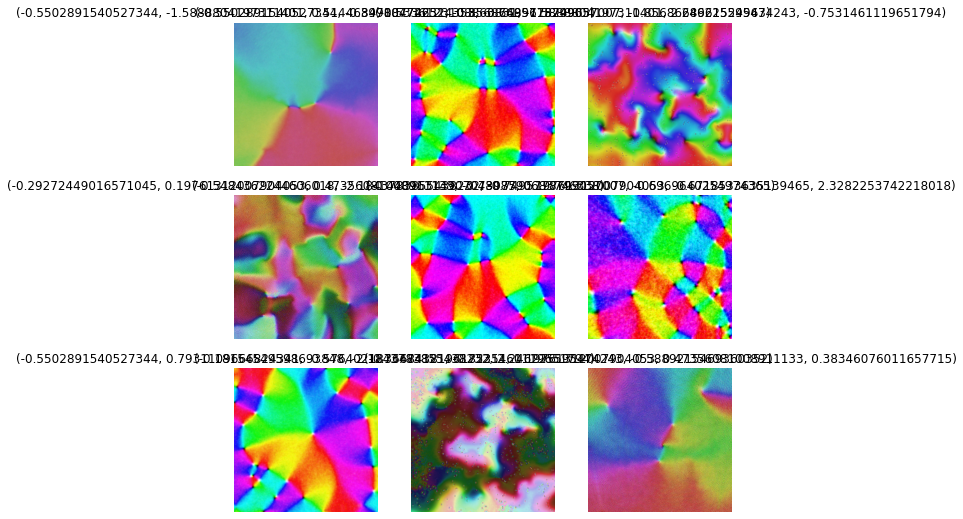

In [9]:
dls.show_batch()

In [10]:
callbacks=([SaveModelCallback(monitor='valid_loss',with_opt=True ), # saving best model 
            EarlyStoppingCallback(monitor='valid_loss',patience=100,)]) # stopping training if calid loss does not improve 

learn = cnn_learner(dls, 
                    resnet18,
                    pretrained=True, 
                    y_range=(-4.0,4.0), 
                    metrics=[mse,mae], 
                    cbs=callbacks) # y_range=(0,data.max())

In [11]:
#learn.lr_find()

In [12]:
learn.fit_one_cycle(500, 1.0e-4)

epoch,train_loss,valid_loss,mse,mae,time
0,7.548791,4.687284,4.687284,1.782884,07:15
1,7.444777,4.836634,4.836634,1.819854,07:17
2,7.460588,4.742148,4.742148,1.799049,07:09
3,7.432175,4.522463,4.522463,1.745807,07:13
4,7.347596,4.635907,4.635907,1.784013,07:35
5,7.301965,4.170914,4.170914,1.683198,07:18
6,7.180804,4.157401,4.157401,1.675465,07:12
7,7.122730,4.092440,4.092440,1.667101,07:15
8,7.062274,3.911510,3.911510,1.625487,07:17
9,6.946557,3.897502,3.897502,1.602343,07:15


Better model found at epoch 0 with valid_loss value: 4.687284469604492.
Better model found at epoch 3 with valid_loss value: 4.522462844848633.
Better model found at epoch 5 with valid_loss value: 4.170914173126221.
Better model found at epoch 6 with valid_loss value: 4.157400608062744.
Better model found at epoch 7 with valid_loss value: 4.092440128326416.
Better model found at epoch 8 with valid_loss value: 3.9115095138549805.
Better model found at epoch 9 with valid_loss value: 3.8975024223327637.
Better model found at epoch 10 with valid_loss value: 3.680588722229004.
Better model found at epoch 11 with valid_loss value: 3.515522003173828.
Better model found at epoch 13 with valid_loss value: 3.4384067058563232.
Better model found at epoch 15 with valid_loss value: 3.353137969970703.
Better model found at epoch 16 with valid_loss value: 3.2258031368255615.
Better model found at epoch 18 with valid_loss value: 3.170746326446533.
Better model found at epoch 19 with valid_loss value: 

In [13]:
pre_results = learn.get_preds()

In [14]:
r2_score(pre_results[1],pre_results[0])

0.8310226569001761

epoch,train_loss,valid_loss,mse,mae,time
0,0.223424,0.165019,0.165019,0.250234,02:59
1,0.224307,0.154096,0.154096,0.243122,02:57
2,0.232714,0.166431,0.166431,0.252884,02:58
3,0.227101,0.154580,0.154580,0.240991,02:59
4,0.227559,0.162088,0.162088,0.247373,02:57
5,0.227827,0.151824,0.151824,0.237132,02:58
6,0.227759,0.163807,0.163807,0.244822,02:57
7,0.219293,0.151501,0.151501,0.234548,02:58
8,0.219797,0.147913,0.147913,0.233536,02:57
9,0.216441,0.148324,0.148324,0.230756,02:58


Better model found at epoch 0 with valid_loss value: 0.1650194227695465.
Better model found at epoch 1 with valid_loss value: 0.1540958285331726.
Better model found at epoch 5 with valid_loss value: 0.15182383358478546.
Better model found at epoch 7 with valid_loss value: 0.15150126814842224.
Better model found at epoch 8 with valid_loss value: 0.1479126513004303.
Better model found at epoch 22 with valid_loss value: 0.14595484733581543.
Better model found at epoch 24 with valid_loss value: 0.13886642456054688.
Better model found at epoch 25 with valid_loss value: 0.1333908885717392.
Better model found at epoch 27 with valid_loss value: 0.13174909353256226.
Better model found at epoch 36 with valid_loss value: 0.1288996785879135.
Better model found at epoch 37 with valid_loss value: 0.12534596025943756.
Better model found at epoch 40 with valid_loss value: 0.12053370475769043.
Better model found at epoch 46 with valid_loss value: 0.11263436824083328.
Better model found at epoch 56 with

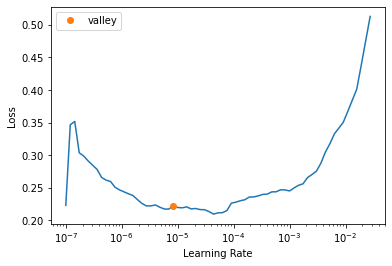

In [15]:
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(500, 1.0e-4)

In [16]:
post_results = learn.get_preds()

In [17]:
r2_score(post_results[1], post_results[0])

0.9389108962791095

In [27]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback, EarlyStoppingCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, Prog

In [40]:
learn.opt.param_groups[0]

{'params': (#30) [Parameter containing:
tensor([[[[-6.5285e-03, -3.3739e-04,  4.6052e-03,  ...,  6.0816e-02,
            2.1947e-02, -8.7278e-03],
          [ 1.3355e-02,  1.1664e-02, -1.0405e-01,  ..., -2.6423e-01,
           -1.2186e-01,  7.5397e-03],
          [-6.1400e-03,  5.9585e-02,  2.9668e-01,  ...,  5.1825e-01,
            2.5693e-01,  6.5540e-02],
          ...,
          [-2.9048e-02,  1.0533e-02,  6.9047e-02,  ..., -3.3174e-01,
           -4.1778e-01, -2.5580e-01],
          [ 2.9290e-02,  3.6496e-02,  6.2071e-02,  ...,  4.1439e-01,
            3.9556e-01,  1.6860e-01],
          [-1.1002e-02, -1.6042e-03, -2.2292e-02,  ..., -1.4378e-01,
           -7.6960e-02,  3.8338e-04]],

         [[-1.4942e-02, -2.7809e-02, -3.3354e-02,  ...,  3.1615e-02,
           -3.1207e-04, -2.8824e-02],
          [ 4.0416e-02,  2.9416e-02, -1.0122e-01,  ..., -3.0858e-01,
           -1.5935e-01, -4.7470e-03],
          [-7.3214e-03,  9.3507e-02,  3.9963e-01,  ...,  7.0206e-01,
            3.6437